# How many emissions came from deforestation?

The emissions widget should be a line chart, with time in years as the x-axis, and emsissions (in tons of carbon, or tones of CO2) as the y-axis, on hover it should show the year and emissions value.

There should be a dynamic sentence which comments on the yearly average emissions over the selected year range.

** Notes ** 

* Use the loss query to get emissions data

* Convert the emission data into C02 emissions (*see th eabg_to_o2 function, below*)

* Users can select date range, as well as Area of Interest (AOI)
    
*more info - not needed for front-end devs*
- for refrence in testing adm0 = BRA, adm1 = 12, adm2 = 1434 is Mato Grosso, Cáceres


# Emissions Calculation

We need to convert the values returned from Charlie's table, which are called `emissions`. In the table these data are actually above ground biomass (units tons). For the country page site we want to display them in most instances as co2 emissions (tons). To do that we need to apply the conversion below.


[BC Discussion](https://basecamp.com/3063126/projects/10727890/todos/338189111#comment_591986621)

In [1]:
#Import Global Metadata etc

%run '0.Importable_Globals.ipynb'

### Note: Conversion function

This widget converts the 'emissions' values from Charlie's table into either Carbon or CO2 emissions.

In [2]:
emissions = 7355734.60097

In [25]:
def abg_to_co2(abg):
    """Convert above ground biomass in tons into carbon emissions in tons
        n.b. above ground biomass is the value labeled 'emissions' in Charlie's table
    """
    return (abg + (0.489 * (abg ** 0.89))) *0.47

def abg_to_c(abg):
    """Convert above ground biomass in tons into biomass carbon in tons
        n.b. above ground biomass is the value labeled 'emissions' in Charlie's table
    """
    return (abg + (0.489 * (abg ** 0.89)))

In [4]:
abg_to_co2(emissions)

3754159.3296786468

### Note

This widget uses the same requests as the 'Loss Stacked Bars' Widget

In [9]:
# Variables

threshold=30
adm0 = 'BRA'
adm1 = None
adm2 = None

start=2001
end=2016

location = "All Region"
emissions_metric = 'biomass_carbon_Mt' # or 'co2_emissions_Mt'

tags = ["climate"]
selectable_polynames = ['gadm28',
                        'bra_biomes',
                        'mining',
                        'wdpa',
                        'primary_forest',
                        'ifl_2013']

In [6]:
# get a human readable {id: name} json for either admin 1 or 2 level as needed:

areaId_to_name = None
if adm2:
    tmp = get_admin2_json(iso=adm0, adm1=adm1)
    areaId_to_name ={}
    for row in tmp:
        areaId_to_name[row.get('adm2')] = row.get('name')
if adm1 and not adm2:
    tmp = get_admin1_json(iso=adm0)
    areaId_to_name={}
    for row in tmp:
        areaId_to_name[row.get('adm1')] = row.get('name')

In [7]:
def loss_queries(p_name, adm0, adm1=None, adm2=None, threshold=30):
    if adm2:
        print(f'Request for adm2 area')
        sql = (f"SELECT polyname, year_data.year as year, "
               f"SUM(year_data.area_loss) as area, "
               f"SUM(year_data.emissions) as emissions "
               f"FROM data "
               f"WHERE polyname = '{p_name}' "
               f"AND iso = '{adm0}' "
               f"AND adm1 = {adm1} "
               f"AND adm2 = {adm2} "
               f"AND thresh= {threshold} "
               f"GROUP BY polyname, iso, nested(year_data.year)")
        return sql
    elif adm1:
        print('Request for  adm1 area')
        sql = (f"SELECT polyname, year_data.year as year, "
               f"SUM(year_data.area_loss) as area, "
               f"SUM(year_data.emissions) as emissions "
               f"FROM data "
               f"WHERE polyname = '{p_name}' "
               f"AND iso = '{adm0}' "
               f"AND adm1 = {adm1} "
               f"AND thresh= {threshold} "
               f"GROUP BY polyname, iso, nested(year_data.year)")
        return sql
    elif adm0:
        print('Request for  adm0 area')
        sql = (f"SELECT polyname, year_data.year as year, "
               f"SUM(year_data.area_loss) as area, "
               f"SUM(year_data.emissions) as emissions "
               f"FROM data "
               f"WHERE polyname = '{p_name}' " 
               f"AND iso = '{adm0}' "
               f"AND thresh= {threshold} "
               f"GROUP BY polyname, iso, nested(year_data.year)")
        return sql



In [26]:
#ds = '499682b1-3174-493f-ba1a-368b4636708e'
url = f"https://production-api.globalforestwatch.org/v1/query/{ds}"

print(adm0)

# Next, get the loss data grouped by year
sql = loss_queries(p_name=polynames[location], adm0=adm0, 
                   adm1=adm1, adm2=adm2, threshold=threshold)    
print(sql) # loss query
properties = {"sql": sql}
r = requests.get(url, params = properties)
print(r.url)
print(f'Status: {r.status_code}')
pprint(r.json())


# # Extract the year, and loss in hectares, and emissions units, and calculate the relative loss in %
d = {}
for row in r.json().get('data'):
    tmp_yr = float(row.get('year'))
    if tmp_yr > 2000:
        try:
            tmp_area = float(row.get('area'))
        except:
            tmp_area = None
            
        try:
            tmp_area_pcnt = (tmp_area / y2010_relative_extent) * 100
        except:
            tmp_area_pcnt = None
            
        try:
            tmp_emiss = float(row.get('emissions'))
        except:
            tmp_emiss = None
            
        d[int(tmp_yr)] = {
                            'biomass_carbon_Mt': abg_to_c(tmp_emiss)/(1e6),
                            'co2_emissions_Mt': abg_to_co2(tmp_emiss)/1e6
        }
pprint(d)

BRA
Request for  adm0 area
SELECT polyname, year_data.year as year, SUM(year_data.area_loss) as area, SUM(year_data.emissions) as emissions FROM data WHERE polyname = 'gadm28' AND iso = 'BRA' AND thresh= 30 GROUP BY polyname, iso, nested(year_data.year)
https://production-api.globalforestwatch.org/v1/query/499682b1-3174-493f-ba1a-368b4636708e?sql=SELECT+polyname%2C+year_data.year+as+year%2C+SUM%28year_data.area_loss%29+as+area%2C+SUM%28year_data.emissions%29+as+emissions+FROM+data+WHERE+polyname+%3D+%27gadm28%27+AND+iso+%3D+%27BRA%27+AND+thresh%3D+30+GROUP+BY+polyname%2C+iso%2C+nested%28year_data.year%29
Status: 200
{'data': [{'area': 2743646,
           'emissions': 451662674,
           'iso': 'BRA',
           'polyname': 'gadm28',
           'year': 2001},
          {'area': 3504343,
           'emissions': 599104504,
           'iso': 'BRA',
           'polyname': 'gadm28',
           'year': 2002},
          {'area': 3245861,
           'emissions': 540572102,
           'iso': '

In [45]:
average_emissions = total_emissions/(end-start)

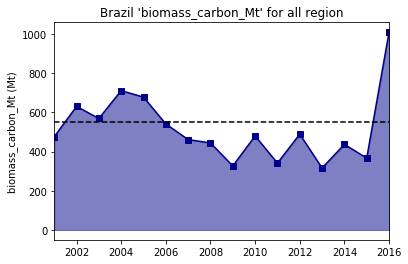

In [46]:
if adm0 and not adm1 and not adm2:
    dynamic_title = (f"{iso_to_countries[adm0]} '{emissions_metric}' for {location.lower()}")
elif adm0 and adm1 and not adm2: 
    dynamic_title = (f"{areaId_to_name[adm1]} '{emissions_metric}' for {location.lower()}")
elif adm0 and adm1 and adm2:
    dynamic_title = (f"{areaId_to_name[adm2]} '{emissions_metric}' for {location.lower()}")


emissions = []
total_emissions = 0
for val in d.values():
    if val.get(emissions_metric):
        emissions.append(val.get(emissions_metric))
        total_emissions += val.get(emissions_metric)
    else:
        emissions.append(0)

years = d.keys()
width = 0.35
fig, ax = plt.subplots()
rects1 = ax.plot(years, emissions, width, color='darkblue', marker='s')
ax.set_xlim([start,end])
ax.plot([2001,2016],[average_emissions, average_emissions], 'k--')
ax.fill_between(years, 0, emissions, color='darkblue', alpha=0.5)

# add some text for labels, title and axes ticks
ax.set_ylabel(f'{emissions_metric} (Mt)')
ax.set_title(dynamic_title)
plt.show()

### NOTE dotted line shows average loss per year over selected period

In [44]:
# Dynamic Sentence
if emissions_metric == 'biomass_carbon_Mt' :
    emission_type = 'carbon'
elif emissions_metric == 'co2_emissions_Mt':
        emission_type = 'CO2'

print(f"Between {start} and {end}, ",end="")
print(f"{total_emissions} million tons of {emission_type} were released into ", end="")
print(f"the atmosphere as a result of forest loss ", end="")


if location == 'All Region':
      print(f"", end="")
elif locations == 'Mining':
      print(f"in {location.lower()} regions ", end="")
else:
      print(f"in {location.lower()} ", end="")
        
print(f"where tree canopy is greater than {threshold}%. ", end="")


Between 2001 and 2016, 8282.20280378778 million tons of carbon were released into the atmosphere as a result of forest loss where tree canopy is greater than 30%. 